<a href="https://colab.research.google.com/github/sjgrider256/Digital_Forest/blob/main/Species_Classification_Train_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Step 1: Import libraries

In [ ]:
import numpy as np
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# Step 2: Load dataset

Mount dataset from google drive

Note: you must copy [the root directory folder](https://) to your google drive (see README) before mounting the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# Point to the folder containing both class folders
data_dir = '/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/Datasets/Training'

#  TensorFlow will automatically assign class labels based on folder names in alphabetical order:

Load data. Split into training and validaiton sets (80/20). Resize and assign label mode to "categorical" for one-hot encoding. If using EfficientNetB0, image size = 224 x 224. 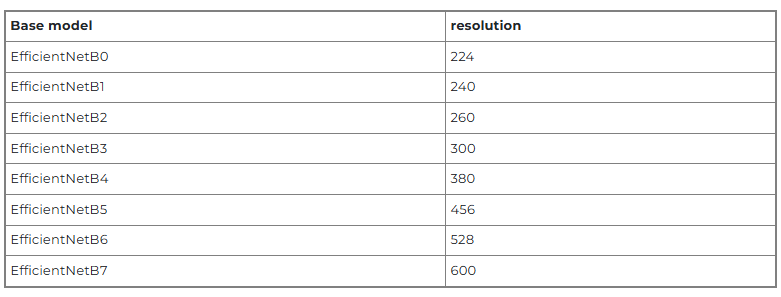

Note: higher models of EfficientNet with large image inputs decrease in efficiancy as the depth and width of the model increases.

In [ ]:
#Tensoflow automatically labels images based on their folder names.
from tensorflow.keras.utils import image_dataset_from_directory
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 300
BATCH_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"      #for one-hot encoding
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

print("Class names:", train_ds.class_names)


Confirm resized images

In [ ]:
# Get a batch of images and labels
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    # Display a few images
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break


Count images in each folder and assign class labels

In [ ]:
import os

# Define the subfolder paths
hemlock_dir = os.path.join(data_dir, "Hemlocks-Training")
not_hemlock_dir = os.path.join(data_dir, "Not Hemlocks-Training")

# Count .png files in each folder (you can change to .jpg if needed)
hemlock_count = len([f for f in os.listdir(hemlock_dir) if f.lower().endswith(".png")])
not_hemlock_count = len([f for f in os.listdir(not_hemlock_dir) if f.lower().endswith(".png")])

print(f"Hemlock images (class 1): {hemlock_count}")
print(f"Not Hemlock images (class 0): {not_hemlock_count}")

# Build class_labels list
class_labels = [0] * not_hemlock_count + [1] * hemlock_count


#Step 3: Set up data augmentation + prefetching for optimization


In [ ]:
#Let TensorFlow optimize performance automatically
AUTOTUNE = tf.data.AUTOTUNE
#Apply random augmentation to each training image
data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

#Take x (the image) and apply your data augmentation pipeline to it.
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
#Leave y (the label) unchanged.This modifies every image on-the-fly as it is fed to the model, without changing the stored data.

#apply prefetching to load data batches ahead of time to keep training smooth and fast
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Augmentation is applied dynamically during training. The images are transformed on the fly every time they are fetched by the model, meaning they are not stored in a seperate datset after augmentation. The code below will display augmentation examples

In [ ]:
# Extract one image
for images, labels in train_ds.take(1):
    image = images[0]
    break

# Show multiple augmentations of the same image
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(tf.cast(augmented_image[0], tf.uint8))
    plt.title("Augmented")
    plt.axis("off")


After training, if accuracy rates are low because of overfitting. Consider adding more aggressive augmentation to avoid over fitting by incrasing contrast, adding random brightness and flips.

*Be careful that augmentation is not distorting your features with rotations, translations, and gaussian noise.


# Step 4: Build model


Assign class weights (particularly useful if datasets are imbalanced).


In [ ]:
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weight_dict = dict(enumerate(weights))
print("Class weights:", class_weight_dict)


In [ ]:

from keras.applications import EfficientNetB0
from keras import layers, models, optimizers

def build_model(num_classes=2):
    # Input shape matches resized image dimensions
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Load EfficientNetB0 base model without the top classifier layer
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    base_model.trainable = False  # Freeze base model initially

    # Add global average pooling and a dropout layer
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Final dense layer for 2-class softmax
    outputs = layers.Dense(num_classes, activation='softmax', name="classifier")(x)

    # Build and compile model
    model = models.Model(inputs, outputs, name="EfficientNetB0_Binary")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',   # because labels are one-hot
        metrics=['accuracy']
    )

    return model



Create the Model

In [ ]:
model = build_model()
model.summary()


#Step 5: Training


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Optional: Save best model to Google Drive
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)

# Optional: Stop training early if val accuracy stops improving
early_stop_cb = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25, #increase epoch size if loss rate shows continual improvement
    callbacks=[checkpoint_cb, early_stop_cb],
    class_weight=class_weight_dict
)


Save the model to your directory

In [ ]:
model.save('/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/Hemlock_Model.keras')

#Step 6: Evaluation


Print final accuracy

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final validation accuracy: {val_accuracy:.2f}")


Visualize accuracy & loss

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


Step 7: Prediction(full dataset)

In [ ]:
import tensorflow as tf
from keras.models import load_model


#Load the trained model
model_path = '/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/Hemlock_Model.keras'

model = load_model(model_path)


# load non-shuffled full dataset for prediction
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=False,  # important to match file order and label order
    image_size= IMG_SIZE,
    batch_size=32,  #or load batch_size = BATCH_SIZE if loaded previously
    label_mode="categorical"  #assigns class labels alphabetically by default: Hemlock = [0,1] now
)

# Display class names
class_names = full_ds.class_names
print("Class names:", class_names)


# initialize containers for true/predicted labels and images
y_true = []
y_pred = []
all_images = []

# Loop over prediction dataset
for images, labels in full_ds:  # full_ds created earlier with shuffle=False
    preds = model.predict(images) # forward pass through the model
    y_true.extend(tf.argmax(labels, axis=1).numpy()) # convert one-hot to class index
    y_pred.extend(tf.argmax(preds, axis=1).numpy()) # same for predictions
    all_images.extend(images.numpy().astype("uint8"))  # save for visualization

#argmax returns the index of the largest value, converting prediction from softmax probability outputs ([0.92, 0.08] to [1,0])
#tf.argmax(labels, axis=1) gets the index of the "1" in each row: [1, 0] → 0, [0, 1] → 1
#numpy() converts the Tensor to a NumPy array.
#extend() appends the result to the running list y_true.


Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix - EfficientNetB0 Classifier")
plt.show()


Note: if your target class (label = 1) dataset is under represented in the dataset (small ratio), then the model will be conservative and only predict 1 postive when confidence levels are high, yeilding more false negatives (type II error).

Save predictions as CSV

In [ ]:
import pandas as pd
import os

# Get filenames
file_paths = full_ds.file_paths  # if your full_ds still has this attribute

# Build initial predictions dataframe
predictions_df = pd.DataFrame({
    'filename': [os.path.basename(p) for p in file_paths],
    'true_label': y_true,
    'predicted_label': y_pred,
    'true_class': [class_names[i] for i in y_true],
    'predicted_class': [class_names[i] for i in y_pred]
})

# Save predictions to CSV
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")


Visualize predictions

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# Show 16 predictions
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(all_images[i])
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    color = "green" if y_true[i] == y_pred[i] else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


Count misclassifications

In [ ]:
import numpy as np

y_true = np.array(y_true)
y_pred = np.array(y_pred)

num_correct = np.sum(y_true == y_pred)
num_total = len(y_true)
accuracy = num_correct / num_total

print(f"Prediction accuracy on full dataset: {accuracy:.2%}")
print(f"Total misclassifications: {np.sum(y_true != y_pred)}")


Show missclassifications: analyze missed features


In [ ]:
import matplotlib.pyplot as plt

# Convert everything to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
all_images = np.array(all_images)

# Find misclassified indices
misclassified_idxs = np.where(y_true != y_pred)[0]

print(f"Found {len(misclassified_idxs)} misclassified images.")

# Plot misclassified images
plt.figure(figsize=(15, 15))

for i, idx in enumerate(misclassified_idxs[:25]):  # Show up to 25 mistakes
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(all_images[idx])
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
    plt.axis("off")

plt.tight_layout()
plt.show()


#Step 7: Output (georeference predictions)

Merge the saved model output/predictions csv with the combined_metadata file.  Combined_metadata_(merge_with_predictions).xlsx is combined meta data of image extractions from the GeoTIFF/orthomosaic. The metadata file stores xmin, xmax, ymin, ymax geometries of each image extracted from the orthomosiac.

In [ ]:
import pandas as pd
import os
from google.colab import files

# Step 1: Load the saved predictions
predictions_df = pd.read_csv("predictions.csv")

# Step 2: Clean the filenames (in case they are still full paths)
predictions_df['filename'] = predictions_df['filename'].apply(lambda x: os.path.basename(x))

# Step 3: Load the combined metadata (manually combined)
metadata = pd.read_excel('/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/Datasets/Combined_metadata_(merge_with_predictions).xlsx')

# Step 4: Merge predictions with metadata
merged = pd.merge(metadata, predictions_df, on="filename", how="inner")

# Step 5: Save the final combined output
merged.to_csv("final_predictions_with_coordinates.csv", index=False)

# Step 6: Download the file (then upload file to Dataset folder in google drive)
files.download("final_predictions_with_coordinates.csv")



#Step 8: Visualize in GIS


Predictions in Step 6 are saved with in pixel coordinates. Convert pixel coordinates to UTM CRS to visualize predictions on a Geogrphaical Information System..

In [ ]:
# Install geopandas and rasterio if not already installed
!pip install geopandas rasterio pyproj shapely --quiet

# Imports
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import box

# Paths
merged_csv_path = "/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/Datasets/final_predictions_with_coordinates (1).csv"
raster_path = "/content/drive/MyDrive/Digital_Forest_(Eastern_Hemlock)/GeoTiffs/Fixed-Fiery-Gizzard-Trail-5-10-2025-orthophoto.tif"  # orthophoto/GeoTIFF

# Load merged CSV
df = pd.read_csv(merged_csv_path)

# Open raster to get transform and CRS
with rasterio.open(raster_path) as src:
    transform = src.transform
    crs = src.crs  # Coordinate Reference System (e.g., UTM Zone 16N)

print(f"CRS Loaded: {crs}")

# Function to convert pixel bounds to real-world bounds
def pixel_to_world_bounds(row):
    xmin_px, ymin_px, xmax_px, ymax_px = row['xmin_px'], row['ymin_px'], row['xmax_px'], row['ymax_px']
    top_left = rasterio.transform.xy(transform, ymin_px, xmin_px, offset='ul')
    bottom_right = rasterio.transform.xy(transform, ymax_px, xmax_px, offset='ul')
    return top_left[0], bottom_right[1], bottom_right[0], top_left[1]  # xmin, ymin, xmax, ymax

# Apply conversion
df[['xmin_world', 'ymin_world', 'xmax_world', 'ymax_world']] = df.apply(pixel_to_world_bounds, axis=1, result_type='expand')

# Create bounding box geometries
geometry = df.apply(lambda row: box(row['xmin_world'], row['ymin_world'], row['xmax_world'], row['ymax_world']), axis=1)

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

#viaulize correct predictions
gdf["is_correct"] = gdf["true_label"] == gdf["predicted_label"]

# Save output to GeoPackage
gdf.to_file("/content/predicted_bounding_boxes.gpkg", layer="tree_predictions", driver="GPKG")

print("✅ GeoPackage saved at /content/predicted_bounding_boxes.gpkg! Ready to import into QGIS.")


In [ ]:
# Download the GPKG file directly
files.download("/content/predicted_bounding_boxes.gpkg")

**Import layers into GIS:**  

Download the GeoTIFF/orthomosaic to your local drive. Create a new project in QGIS. Upload the GeoTIFF as a raster layer and the new gpkg file as a vector
layer (e.g., Layer > Add layer > Add Raster layer)

 The CRS should automatically update to match the layers (bottom right of window)


**Create categorized labels to visualize predictions**

Right click on the vector layer in the layers pannel --> Properties--> Symbology --> Change top drowpdown bar from "single" to "categorized" --> Enter "predicted_labe=1" into the Expression Builder--> Save expression--> hit "Classify"-->

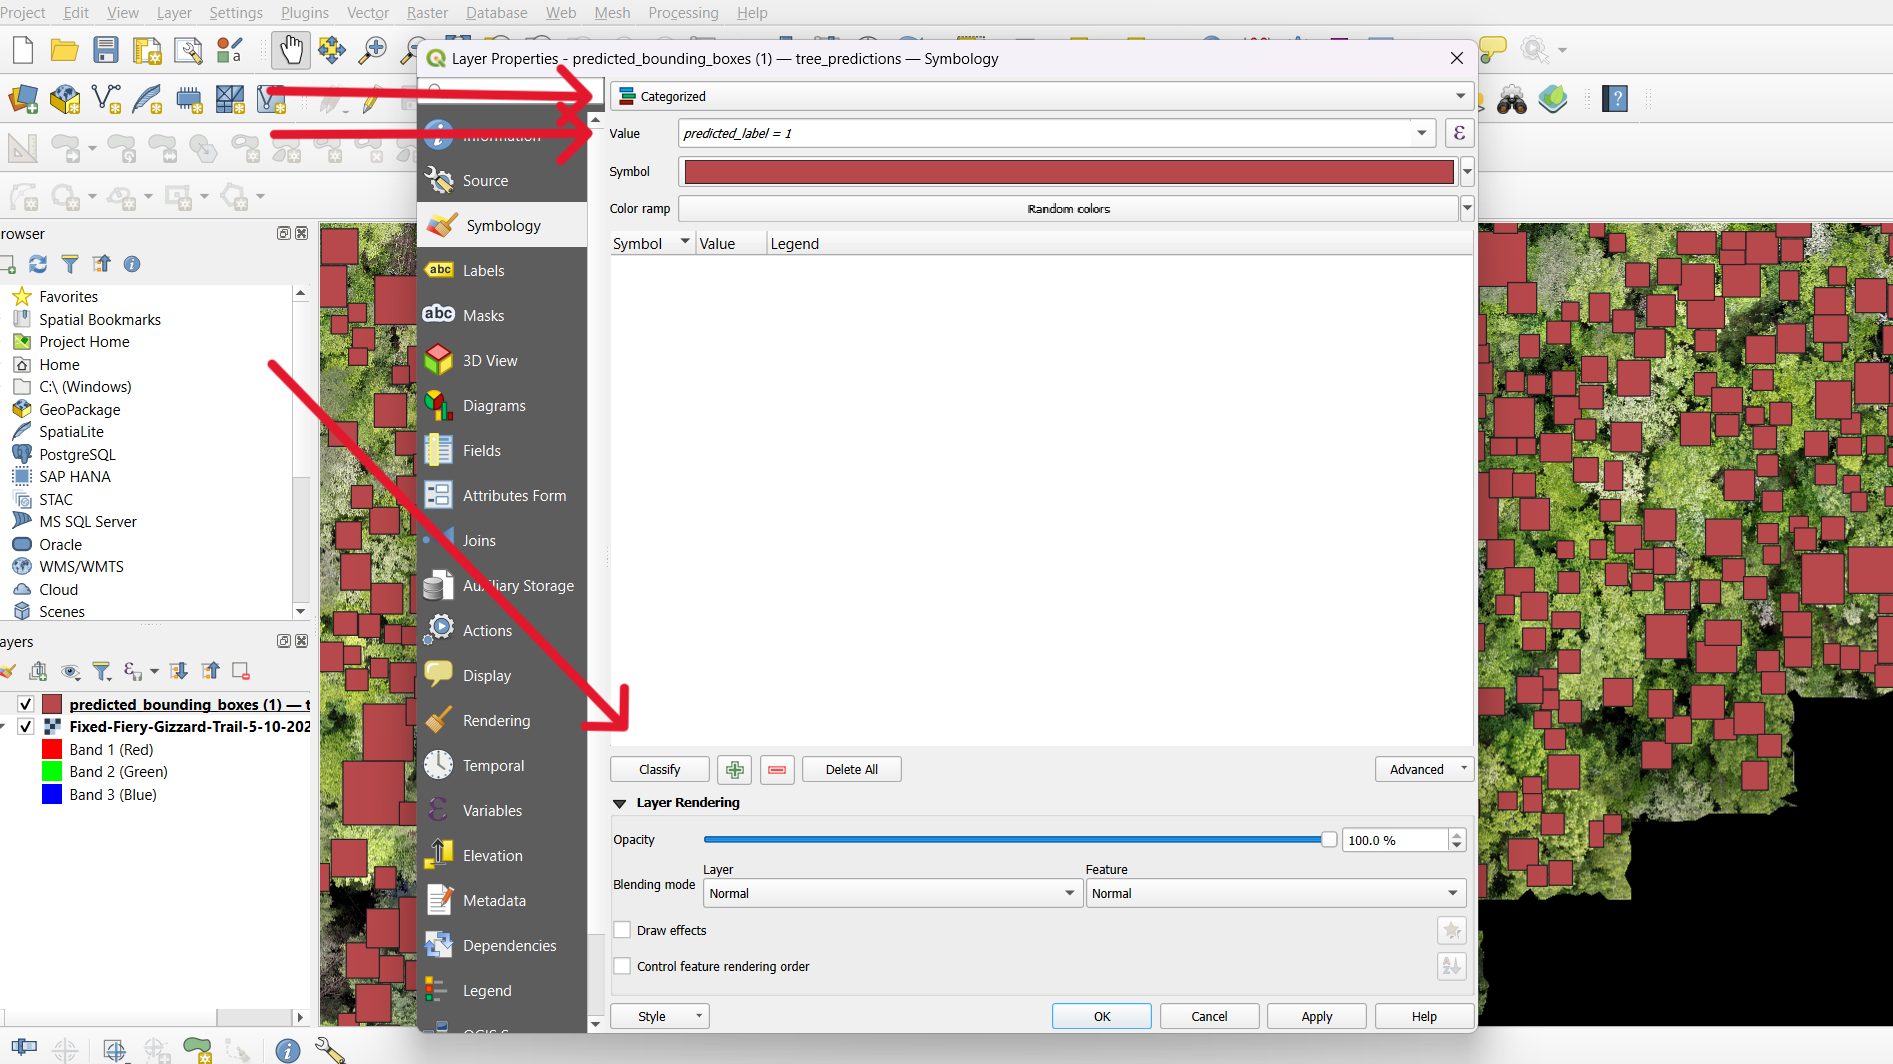

Adjust symbology: change fill type to outline for bounding boxes.